In [2]:
import tensorflow as tf
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.losses import LogCosh
from keras.metrics import MeanSquaredError, MeanAbsoluteError,RootMeanSquaredError
from keras import Sequential, layers
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

2024-08-18 19:15:50.591561: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 19:15:50.591676: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 19:15:50.720271: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Hyper parameters
PATCH_SIZE = 32
BATCH_SIZE = 200
EPOCHS = 80

In [4]:
val_files = {
    "../patches-32/skull_decimated.npy", 
    "../patches-32/ant_decimated.npy", 
    "../patches-32/vase_decimated.npy", 
    "../patches-32/isis_decimated.npy", 
    "../patches-32/teddy_decimated.npy",
    "../patches-32/teapot_decimated.npy"
}

patche_files = sorted(glob.glob('../patches-32/*.npy'))
patche_files = list(set(patche_files) - val_files)
saliency_files = [
    f"../3d-meshes/{os.path.basename(f).replace('.npy', '.txt')}" 
    for f in patche_files
]

print('Number of patches:', len(patche_files))
print('Number of saliency maps:', len(saliency_files))

Number of patches: 43
Number of saliency maps: 43


In [5]:
X_train = np.concatenate([np.load(f, mmap_mode="r").astype(np.float32) for f in patche_files])
y_train = np.concatenate([np.loadtxt(f).astype(np.float32) for f in saliency_files])
    
X_train, y_train = shuffle(X_train, y_train)
X_train.shape, y_train.shape, X_train.dtype, y_train.dtype

((859999, 32, 32, 3), (859999,), dtype('float32'), dtype('float32'))

In [6]:
tf.keras.mixed_precision.set_global_policy('mixed_float16')
model = Sequential()

model.add(layers.Conv2D(filters = 16, kernel_size = (3,3), activation ='relu',
                        input_shape=(PATCH_SIZE, PATCH_SIZE, 3), padding="same", strides=(1, 1)))
model.add(layers.BatchNormalization(axis=3))
model.add(layers.Conv2D(filters = 16, kernel_size = (3,3), activation ='relu', padding="same", strides=(1, 1)))
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2, 2), padding="valid"))
model.add(layers.BatchNormalization(axis=3))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation ='relu', padding="same", strides=(1, 1)))
model.add(layers.BatchNormalization(axis=3))
model.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation ='relu', padding="same", strides=(1, 1)))
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2, 2), padding="valid"))
model.add(layers.BatchNormalization(axis=3))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation ='relu', padding="same", strides=(1, 1)))
model.add(layers.BatchNormalization(axis=3))
model.add(layers.Conv2D(filters = 64, kernel_size = (3,3), activation ='relu', padding="same", strides=(1, 1)))
model.add(layers.MaxPooling2D(pool_size=(2,2), strides=(2, 2), padding="valid"))
model.add(layers.BatchNormalization(axis=3))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())

model.add(layers.Dense(256, activation = "relu")) #Fully connected layer
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(64, activation = "relu")) #Fully connected layer
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(1, activation = "sigmoid")) # output layer

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

model.compile(optimizer=optimizer, loss=LogCosh(), metrics=[
            MeanSquaredError(name='mse'),
            MeanAbsoluteError(name='mae'),
            RootMeanSquaredError(name='rmse'),
])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 353,169 (1.35 MB)

 Trainable params: 352,081 (1.34 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [7]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [8]:
# fit the model
saliency_model = model.fit(
    X_train, y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_split=0.2, 
    verbose=1,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/80
  11/3440 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - loss: 0.1297 - mae: 0.4450 - mse: 0.2821 - rmse: 0.5312

I0000 00:00:1724008775.598145      82 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1724008775.644436      82 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3440/3440 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0622 - mae: 0.2578 - mse: 0.1354 - rmse: 0.3622

W0000 00:00:1724008813.580911      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1724008819.738363      81 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3440/3440 ━━━━━━━━━━━━━━━━━━━━ 72s 14ms/step - loss: 0.0622 - mae: 0.2577 - mse: 0.1353 - rmse: 0.3622 - val_loss: 0.0150 - val_mae: 0.1052 - val_mse: 0.0320 - val_rmse: 0.1788 - learning_rate: 1.0000e-04
Epoch 2/80
3440/3440 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - loss: 0.0173 - mae: 0.1120 - mse: 0.0370 - rmse: 0.1922 - val_loss: 0.0139 - val_mae: 0.1058 - val_mse: 0.0294 - val_rmse: 0.1716 - learning_rate: 1.0000e-04
Epoch 3/80
3440/3440 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 0.0145 - mae: 0.1040 - mse: 0.0307 - rmse: 0.1752 - val_loss: 0.0129 - val_mae: 0.1000 - val_mse: 0.0273 - val_rmse: 0.1651 - learning_rate: 1.0000e-04
Epoch 4/80
3440/3440 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - loss: 0.0134 - mae: 0.1005 - mse: 0.0282 - rmse: 0.1680 - val_loss: 0.0129 - val_mae: 0.0979 - val_mse: 0.0273 - val_rmse: 0.1651 - learning_rate: 1.0000e-04
Epoch 5/80
3440/3440 ━━━━━━━━━━━━━━━━━━━━ 24s 7ms/step - loss: 0.0131 - mae: 0.0988 - mse: 0.0275 - rmse: 0.1659 - val_loss: 0.0123 - val_mae: 0.0909 

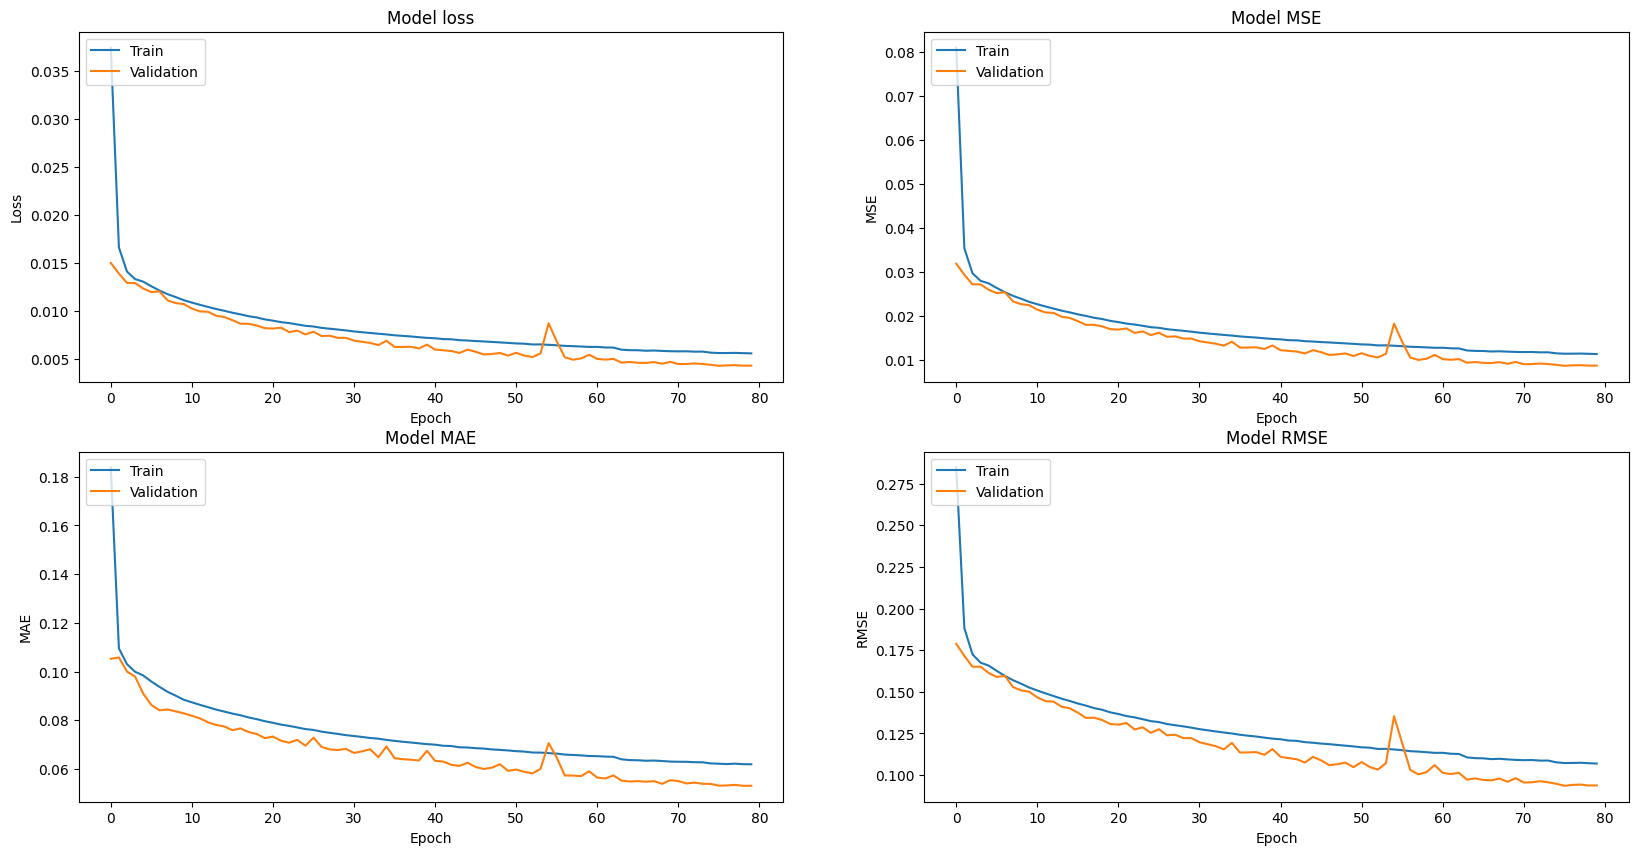

In [9]:
plt.figure(figsize=(20, 10))
# Plot the training and validation loss
plt.subplot(2, 2, 1)
plt.plot(saliency_model.history['loss'][0:])
plt.plot(saliency_model.history['val_loss'][0:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(2, 2, 2)
plt.plot(saliency_model.history['mse'][0:])
plt.plot(saliency_model.history['val_mse'][0:])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(2, 2, 3)
plt.plot(saliency_model.history['mae'][0:])
plt.plot(saliency_model.history['val_mae'][0:])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(2, 2, 4)
plt.plot(saliency_model.history['rmse'][0:])
plt.plot(saliency_model.history['val_rmse'][0:])
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [10]:
model.save('../saved-models/new-model-32.h5')

In [11]:
import gc
del X_train 
del y_train
gc.collect()

16612

In [12]:
# evaluate model
X_test = np.concatenate([np.load(f).astype(np.float32) for f in val_files])
y_test = np.concatenate([np.loadtxt(f"../3d-meshes/{os.path.basename(f).replace('.npy', '.txt')}").astype(np.float32) for f in val_files])
loss, mse, mae, rmse = model.evaluate(X_test, y_test, verbose=1)
print("Loss: ", loss)
print("MSE: ", mse)
print("MAE: ", mae)
print("RMSE: ", rmse)

3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0106 - mae: 0.0810 - mse: 0.0219 - rmse: 0.1478
Loss:  0.009271158836781979
MSE:  0.019068516790866852
MAE:  0.07718298584222794
RMSE:  0.138087660074234
